<a href="https://colab.research.google.com/github/freaky002/Vegetable-Detection-with-Tensorflow-learning-PYTHON/blob/main/TRAIN_veg_Detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

****Vegetable Classification Using Transfer Learning ****

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout

K.clear_session()

#1. Loading the dataset

Establish the project's basic directories' path.

In [ ]:
dataset='/content/drive/MyDrive/Vegetable_Images'

train_folder = os.path.join(dataset,"train")
test_folder = os.path.join(dataset,"validation")
validation_folder = os.path.join(dataset,"test")

determining how many photos are in a folder.(test set)

In [ ]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))

count_files(os.path.join(test_folder))

There are 200 files in Tomato
There are 200 files in Cucumber
There are 200 files in Carrot
There are 200 files in Radish
There are 200 files in Pumpkin
There are 200 files in Cauliflower
There are 200 files in Papaya
There are 200 files in Potato
There are 200 files in Bottle_Gourd
There are 200 files in Bitter_Gourd
There are 200 files in Capsicum
There are 200 files in Brinjal
There are 200 files in Cabbage
There are 200 files in Bean
There are 200 files in Broccoli


As is clear, the dataset is evenly distributed, with each class including:

1000 photos are used as a training set.

for the test set, 200 pictures.

#2. Image Processing

The enhancement of graphical information for human comprehension is the aim of image processing. Increased comprehension of basic manipulation and filtering can also improve feature extraction.

Here, we may choose any vegetable of our choosing, and a comparison between an unprocessed photograph and a random image from the class is provided.

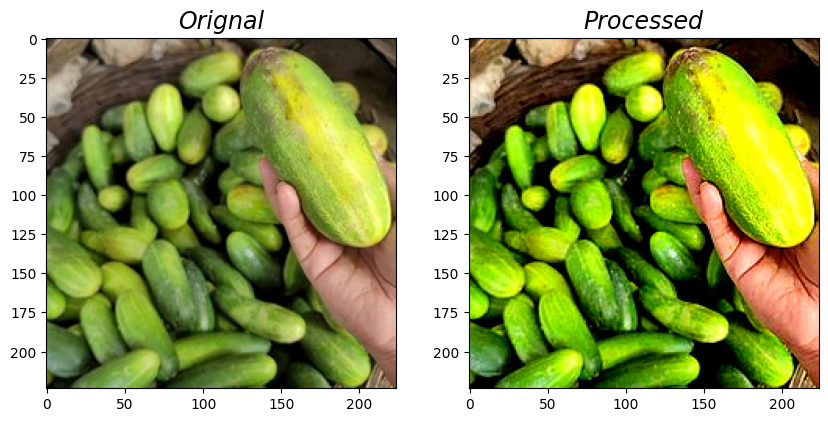

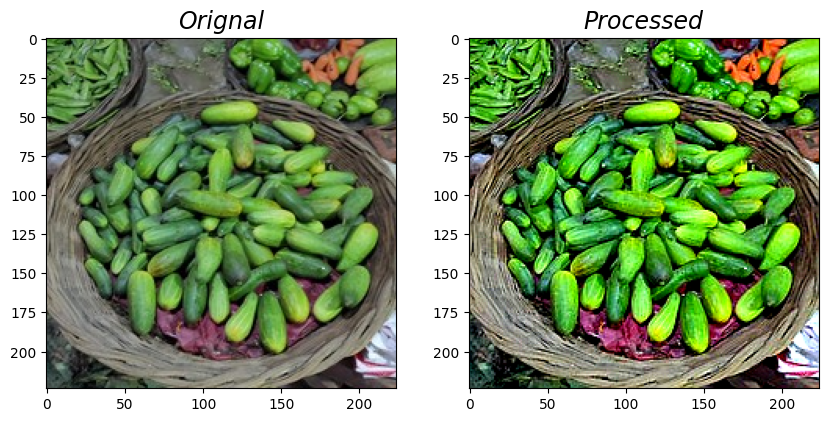

In [ ]:
image_folder="Cucumber"  # The vegetable you want to display
number_of_images=2       # Number of images to display

def Preprocess():
    j=1
    for i in range(number_of_images):

        folder = os.path.join(test_folder,image_folder)
        a=random.choice(os.listdir(folder))

        image=Image.open(os.path.join(folder,a))
        image_duplicate=image.copy()
        plt.figure(figsize=(10,10))

        plt.subplot(number_of_images,2,j)
        plt.title(label='Orignal', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image)
        j+=1

        image1=ImageEnhance.Color(image_duplicate).enhance(1.35)
        image1=ImageEnhance.Contrast(image1).enhance(1.45)
        image1=ImageEnhance.Sharpness(image1).enhance(2.5)

        plt.subplot(number_of_images,2,j)
        plt.title(label='Processed', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image1)
        j+=1

Preprocess()

To draw texture and the viewer's attention, we boosted the color saturation and contrast before sharpening the image. After processing, the picture becomes attractive and brighter.

#3. Data Visualization (EDA)
An essential element in the data analysis process is data visualization, commonly referred to as exploratory data analysis (EDA). In order to visually understand patterns, trends, and relationships within the dataset, it entails constructing graphical representations of the data. Before beginning more complex analysis or modeling, the main objective of EDA is to obtain insights, spot trends, and find possible issues or intriguing aspects in the data.

Any class label (like "capsicum") may be seen when we begin to explore the dataset. Any vegetable can be used to visualize that class's visuals. Additionally, changing the rows and columns variable affects where in the format Matplotlib is positioned.

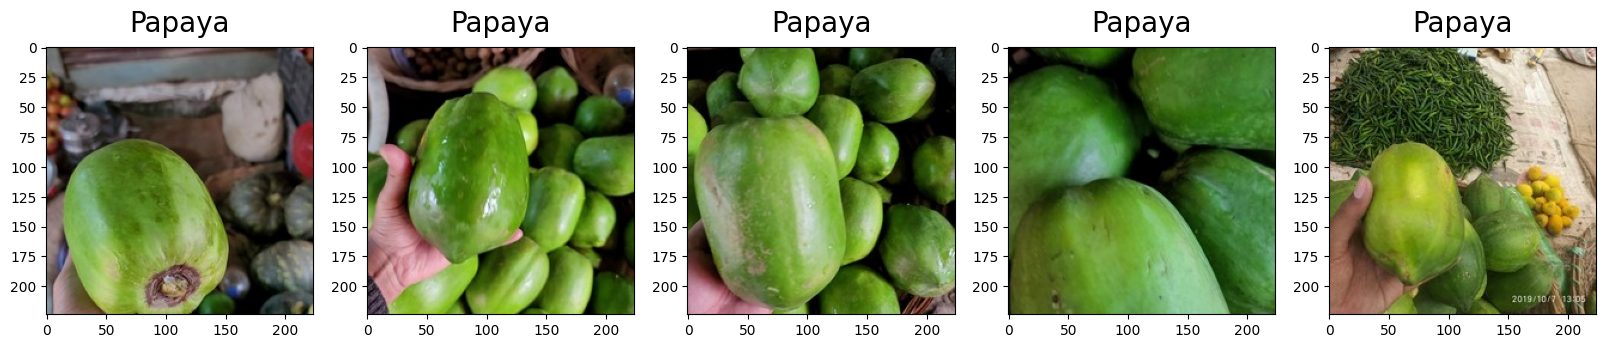

In [ ]:
select_vegetable="Papaya"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_vegetable)
total_images=rows*columns
fig=plt.figure(1, figsize=(20, 10))

for i,j in enumerate(os.listdir(display_folder)):

    img = plt.imread(os.path.join(train_folder,select_vegetable,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_vegetable, pad = 11, size=20)
    plt.imshow(img)

    if i==total_images-1:
        break

#By selecting a random image from each class in the training dataset, let's now display the whole dataset.

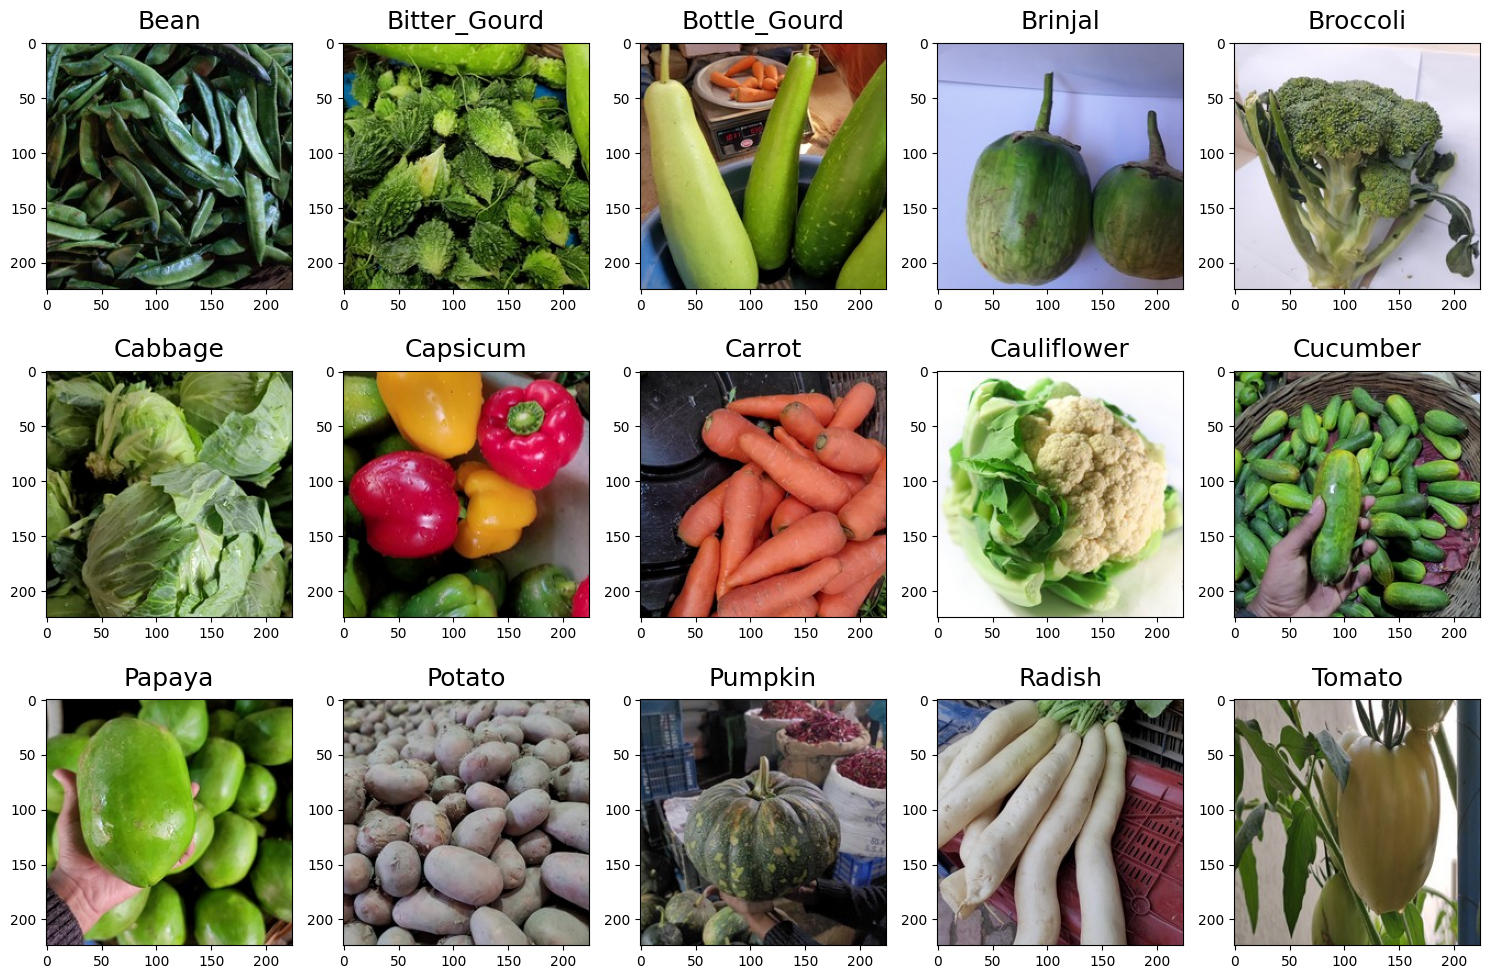

In [ ]:
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))

fig=plt.figure(1, figsize=(15, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(3, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)

plt.tight_layout()

There are 15 distinct types of vegetables (output classes), and one randomly selected image from each class is used to assess the dataset's overall structure and the visibility of various metrics and picture quality. Until now, so good!

#4. Building the Model

Let's begin constructing the transfer learning network for our model's InceptionV3 training.

In [ ]:
IMAGE_SIZE = [224, 224]

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(15, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

#5. Training the Model

In [ ]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder,
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical')

Found 15030 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
class_map = training_set.class_indices
class_map

{'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

In [ ]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
 18/235 [=>............................] - ETA: 56:32 - loss: 0.0269 - accuracy: 0.9913

KeyboardInterrupt: ignored

#Saving the trained model

In [ ]:
model.save('model_inceptionV3_epoch5.h5')

NameError: ignored

#Accuracy and Loss Curves

In [ ]:
def plot_accuracy(history):

    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()

def plot_loss(history):

    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()

plot_accuracy(r)
plot_loss(r)

NameError: ignored

#Model Layers

In [ ]:
print("Total layers in the model : ",len(model.layers),"\n")

layers = [layer.output for layer in model.layers[0:]]
layer_names = []
for layer in model.layers[0:]:
    layer_names.append(layer.name)

print("First layer : ", layer_names[0])
print("InceptionV3 layers : Layer 2 to Layer 311")
print("Our fine tuned layers : ", layer_names[311:314])
print("Final Layer : ", layer_names[314])

Total layers in the model :  315 

First layer :  input_1
InceptionV3 layers : Layer 2 to Layer 311
Our fine tuned layers :  ['global_average_pooling2d', 'dense', 'dropout']
Final Layer :  dense_1


#6. Predictions

Loading the trained model

In [ ]:
K.clear_session()
path_to_model='/content/drive/MyDrive/model_inceptionV3_epoch5.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


#Testing the model on validation set

In [ ]:
validation_data_dir = '/content/drive/MyDrive/Vegetable_Images/test'

validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 3006 images belonging to 15 classes.
Test Accuracy: 0.995


#functions to forecast our model's results

In [ ]:
category={
    0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3 : 'Brinjal', 4: "Broccoli", 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower',
    9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13 : "Radish", 14: "Tomato"
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.

    prediction = model.predict(img_processed)
    index = np.argmax(prediction)

    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)

def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1

    true=filedir.split('/')[-1]

    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))

    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)

        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

#Single image prediction

1/1 [==============================] - 2s 2s/step


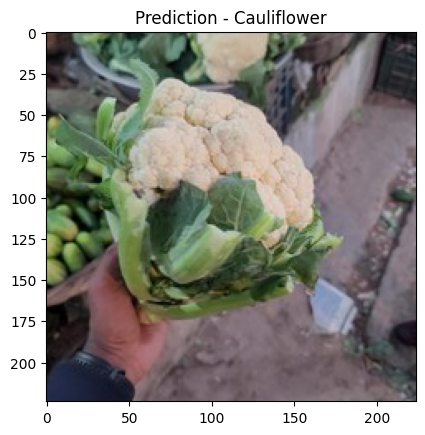

In [ ]:
predict_image(os.path.join(validation_folder,'Cauliflower/1064.jpg'),model)

#Validation directory accuracy prediction

In [ ]:
for i in os.listdir(validation_folder):
    predict_dir(os.path.join(validation_folder,i),model)

1/1 [==============================] - 0s 143ms/step
Accuracy for Pumpkin: 0.99 (199/200)
1/1 [==============================] - 0s 152ms/step
Accuracy for Radish: 0.99 (198/200)
1/1 [==============================] - 0s 142ms/step
Accuracy for Tomato: 0.99 (198/200)
1/1 [==============================] - 0s 146ms/step
Accuracy for Potato: 0.99 (198/200)
1/1 [==============================] - 0s 143ms/step
Accuracy for Brinjal: 0.99 (199/200)
1/1 [==============================] - 0s 149ms/step
Accuracy for Capsicum: 1.00 (200/200)
1/1 [==============================] - 0s 144ms/step
Accuracy for Carrot: 1.00 (200/200)
1/1 [==============================] - 0s 140ms/step
Accuracy for Broccoli: 0.99 (198/200)
1/1 [==============================] - 0s 150ms/step
Accuracy for Papaya: 1.00 (205/206)
1/1 [==============================] - 0s 266ms/step
Accuracy for Cauliflower: 0.99 (198/200)
1/1 [==============================] - 0s 155ms/step
Accuracy for Cabbage: 0.99 (199/200)
1/1 [====

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#7. Evaluation

Loading the model


#Confusion Matrix for evaluating the performance of our classification model.

In [ ]:
def labels_confusion_matrix(validation_folder):

    folder_path=validation_folder

    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i

    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):

        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]

        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(224,224))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0)
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)

    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 15
    cmap="turbo"
    cm_plot_labels = [i for i in range(15)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

1/1 [==============================] - 0s 149ms/step


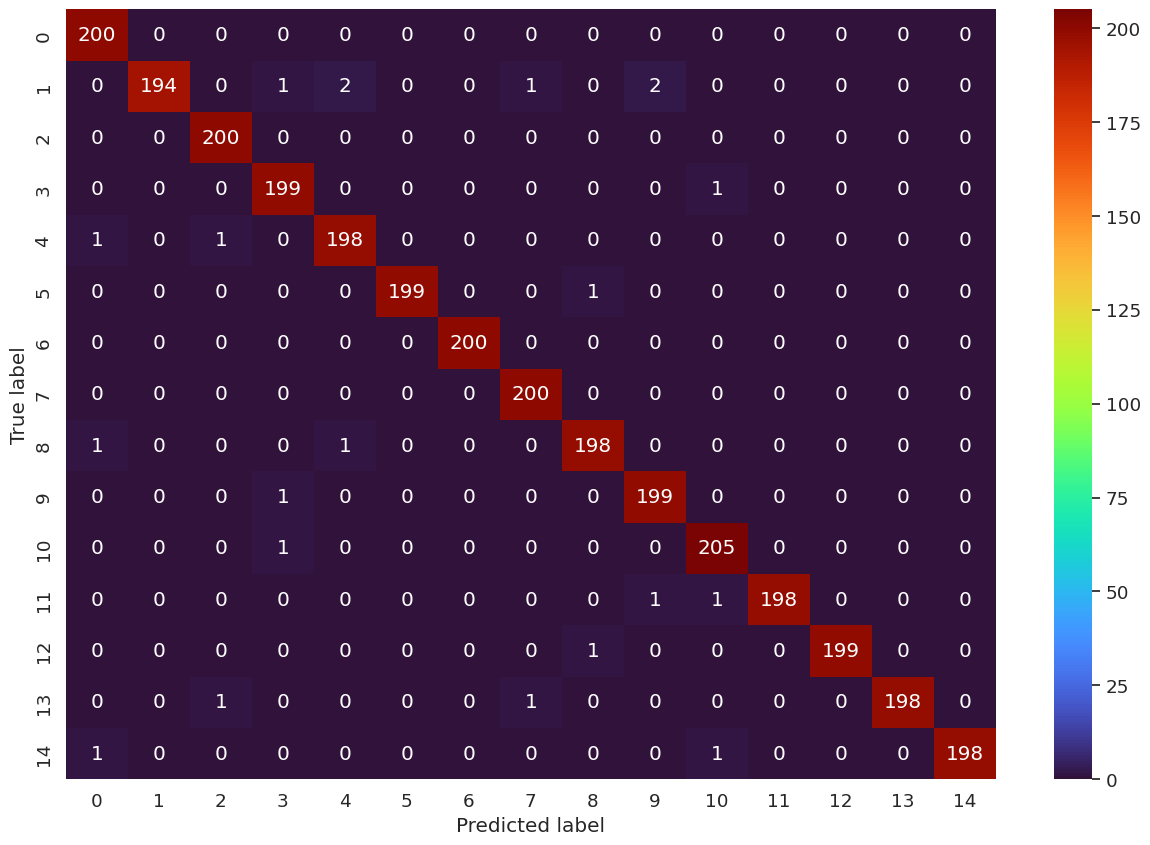

In [ ]:
y_true,y_pred=labels_confusion_matrix(validation_folder)
print_confusion_matrix(y_true,y_pred)

#displaying every false image that our classifier predicted for a certain vegetable group.

In [ ]:
def wrong_input_capture(test_category):

    a=os.path.basename(test_category)
    wrong_array=[]

    for i in os.listdir(test_category):

        imggg=os.path.join(test_category,i)

        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.
        prediction = model.predict(img_processed)

        index = np.argmax(prediction)
        pred=category.get(index)

        if not pred==a:
            wrong_array.append((imggg,pred))

    return wrong_array

def visualize_wrong_input(images):

    fig=plt.figure(1, figsize=(20, 25))
    total_images=len(images)
    rows=math.ceil(float(total_images/3))
    for subplot,(image_path,predicted) in enumerate(images):
        img = plt.imread(image_path)
        fig=plt.subplot(rows, 3, subplot+1)
        fig.set_title("Predicted - {}".format(predicted), pad = 10,size=18)
        plt.imshow(img)

    plt.tight_layout()

1/1 [==============================] - 0s 142ms/step


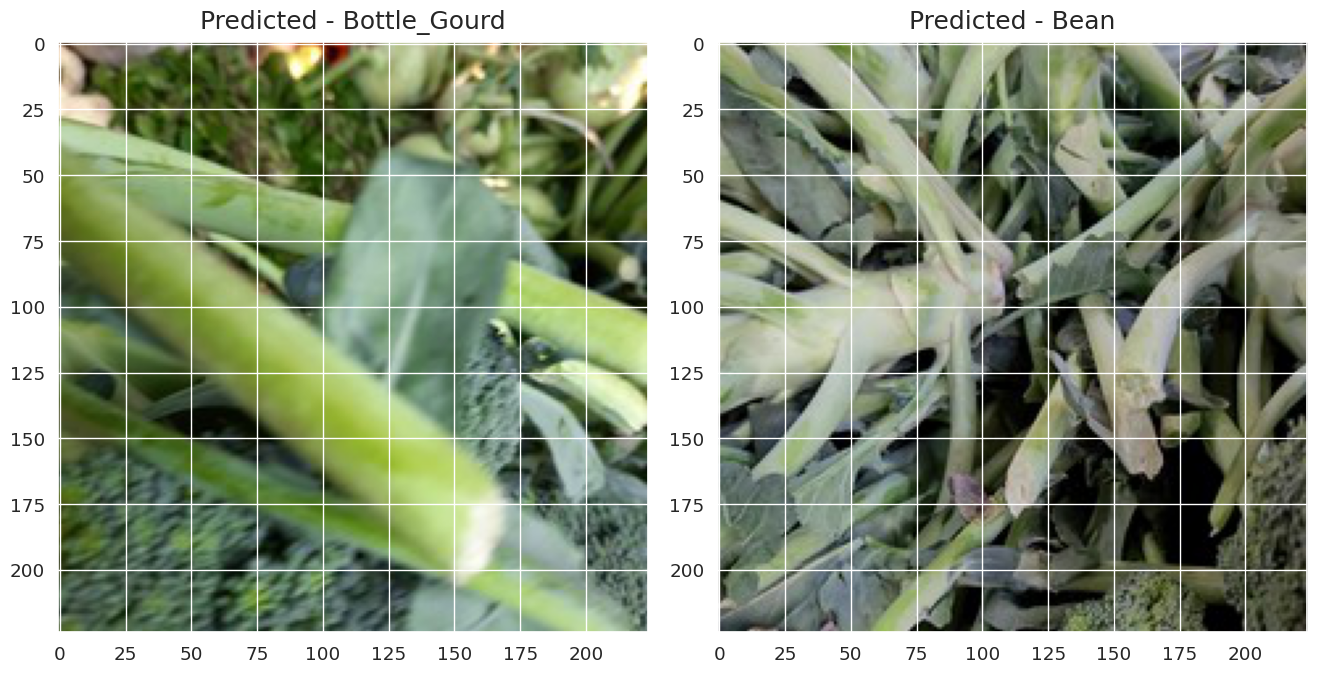

In [ ]:
vegetable="Broccoli"
path=os.path.join(validation_folder,vegetable)
images= wrong_input_capture(path)
visualize_wrong_input(images)